In [1]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import pandas as pd 
from torch import nn
import torch.nn.functional as F
from math import sqrt
import torchvision
from utils import *
from model import *


In [2]:
labels_map_BCCD = {'background': 0, 'RBC': 1, 'WBC': 2, 'Platelets':3}

In [3]:
df = pd.read_csv("data/test.csv")
df["cell_label"] = df['cell_type'].map(labels_map_BCCD)
df.head(100)

,filename,cell_type,xmin,xmax,ymin,ymax,cell_label
0,BloodImage_00000.jpg,WBC,260,491,177,376,2
1,BloodImage_00000.jpg,RBC,78,184,336,435,1
2,BloodImage_00000.jpg,RBC,63,169,237,336,1
3,BloodImage_00000.jpg,RBC,214,320,362,461,1
4,BloodImage_00000.jpg,RBC,414,506,352,445,1
...,...,...,...,...,...,...,...
95,BloodImage_00005.jpg,RBC,324,444,1,87,1
96,BloodImage_00005.jpg,RBC,162,290,1,70,1
97,BloodImage_00005.jpg,RBC,173,260,165,270,1
98,BloodImage_00005.jpg,RBC,139,226,191,296,1


Далее используется модель и фрейворк для неё взятый с https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/tree/master

Были внесены следующие корректировки в исходный код: 
1. Написан свой BCCD_Dataset, однако он сохранил понятие difficulties, т.к. оно используются почти везде в инфраструктуре этой SSD модели. Для датасета BCCD просто difficulties выставлены 0, что эквивалентно тому, что модель будет игнорировать эти поля
2. Убран лишний код из eval.py 
3. В utils.py изменены labels и пофикшен небольшой баг в evaluate_mAp()

BCCD датасет конвертирует картинки с 640x480 в 300x300, попутно конвертируя bbox. 

In [ ]:
class BCCD_Dataset(torch.utils.data.Dataset):
    def __init__(self, root, split, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "BCCD/JPEGImages"))))
        self.df = pd.read_csv(os.path.join(root, "test.csv"))
        self.split = split.upper()
        assert self.split in {'TRAIN', 'TEST'}
    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "BCCD/JPEGImages", self.imgs[idx])
        image = Image.open(img_path).convert("RGB")

        # get bounding box coordinates for each mask
        img_data = df[df['filename'] == self.imgs[idx]]

        num_objs = len(img_data)
        boxes = []
        for i in range(num_objs):
            xmin = img_data["xmin"].tolist()[i] 
            xmax = img_data["xmax"].tolist()[i] 
            ymin = img_data["ymin"].tolist()[i] 
            ymax = img_data["ymax"].tolist()[i]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.as_tensor(img_data['cell_label'].tolist(), dtype=torch.int64)
        difficulties = torch.zeros((len(img_data)), dtype = torch.int8)
        # Apply transformations
        image, boxes, labels, difficulties = transform(image, boxes, labels, difficulties, split=self.split)
        return image, boxes, labels, difficulties
    def collate_fn(self, batch):
        images = list()
        boxes = list()
        labels = list()
        difficulties = list()
        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])
            difficulties.append(b[3])

        images = torch.stack(images, dim=0)

        return images, boxes, labels, difficulties  # tensor (N, 3, 300, 300), 3 lists of N tensors each
    def __len__(self):
        return len(self.imgs)

In [5]:
data = BCCD_Dataset('data', "TRAIN")

In [6]:
data[0]

(tensor([[[0.9303, 0.8961, 0.8618,  ..., 1.0673, 1.1015, 1.1015],
          [0.9132, 0.8961, 0.8618,  ..., 1.0502, 1.0844, 1.1015],
          [0.9132, 0.8961, 0.8789,  ..., 1.0502, 1.0844, 1.1187],
          ...,
          [0.8618, 0.8961, 0.9988,  ..., 1.3242, 1.3755, 1.3584],
          [0.8618, 0.9132, 1.0159,  ..., 1.3413, 1.3927, 1.3755],
          [0.8789, 0.9132, 0.9988,  ..., 1.3927, 1.3927, 1.3927]],
 
         [[0.4853, 0.4853, 0.5028,  ..., 0.6954, 0.6954, 0.6954],
          [0.5378, 0.5203, 0.5028,  ..., 0.6604, 0.6779, 0.6954],
          [0.5378, 0.5203, 0.5203,  ..., 0.6429, 0.6779, 0.7129],
          ...,
          [0.9755, 1.0280, 1.1681,  ..., 1.4657, 1.5007, 1.4832],
          [0.9755, 1.0455, 1.1856,  ..., 1.4832, 1.5357, 1.5182],
          [1.0455, 1.0980, 1.2206,  ..., 1.5532, 1.5532, 1.5532]],
 
         [[0.8099, 0.8971, 1.0191,  ..., 1.1759, 1.2631, 1.3328],
          [0.8797, 0.9319, 1.0191,  ..., 1.1934, 1.2980, 1.3677],
          [0.8971, 0.9842, 1.0539,  ...,

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
model = SSD300(n_classes=len(labels_map_BCCD))

C:\Users\nik\anaconda3\envs\DL\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\nik\anaconda3\envs\DL\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Loaded base model.



In [9]:
model = model.to(device)
#OPTIMIZER
biases = list()
not_biases = list()
lr = 1e-3  # learning rate
for param_name, param in model.named_parameters():
    if param.requires_grad:
        if param_name.endswith('.bias'):
            biases.append(param)
        else:
            not_biases.append(param)
momentum = 0.9  # momentum
weight_decay = 5e-4  # weight decay
optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
                                    lr=lr, momentum=momentum, weight_decay=weight_decay)
#CRITERION
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)

C:\Users\nik\anaconda3\envs\DL\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [10]:
# Custom dataloaders
batch_size = 8
num_epochs = 10
data_folder = 'data'
train_dataset = BCCD_Dataset(data_folder, split='train',)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                           collate_fn=train_dataset.collate_fn,
                                           pin_memory=True)  # note that we're passing the collate function here

In [11]:
from train import *
for epoch in range(num_epochs):
    # One epoch's training
    train(train_loader=train_loader,
          model=model,
          criterion=criterion,
          optimizer=optimizer,
          epoch=epoch)

    # Save checkpoint
    save_checkpoint(epoch, model, optimizer)

Epoch: [0][0/46]	Batch Time 10.748 (10.748)	Data Time 0.524 (0.524)	Loss 16.0540 (16.0540)	
Epoch: [1][0/46]	Batch Time 1.004 (1.004)	Data Time 0.799 (0.799)	Loss 5.9967 (5.9967)	
Epoch: [2][0/46]	Batch Time 0.801 (0.801)	Data Time 0.590 (0.590)	Loss 5.1920 (5.1920)	
Epoch: [3][0/46]	Batch Time 0.697 (0.697)	Data Time 0.510 (0.510)	Loss 3.7988 (3.7988)	
Epoch: [4][0/46]	Batch Time 0.689 (0.689)	Data Time 0.498 (0.498)	Loss 3.3833 (3.3833)	
Epoch: [5][0/46]	Batch Time 0.595 (0.595)	Data Time 0.403 (0.403)	Loss 3.5611 (3.5611)	
Epoch: [6][0/46]	Batch Time 0.746 (0.746)	Data Time 0.544 (0.544)	Loss 3.5590 (3.5590)	
Epoch: [7][0/46]	Batch Time 0.545 (0.545)	Data Time 0.353 (0.353)	Loss 3.3273 (3.3273)	
Epoch: [8][0/46]	Batch Time 0.795 (0.795)	Data Time 0.603 (0.603)	Loss 3.0477 (3.0477)	
Epoch: [9][0/46]	Batch Time 0.668 (0.668)	Data Time 0.475 (0.475)	Loss 3.2259 (3.2259)	


In [12]:
# checkpoint = './checkpoint_ssd300.pth.tar'

# # Load model checkpoint that is to be evaluated
# checkpoint = torch.load(checkpoint)
# model = checkpoint['model']
# model = model.to(device)

model.eval()

# Load test data
test_dataset = BCCD_Dataset('data',
                                split='test')
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                          collate_fn=test_dataset.collate_fn, pin_memory=True)

In [13]:
from eval import *
evaluate(test_loader, model)

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]C:\Users\nik\DL\DLL-27\Task_7\model.py:501: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:28.)
  image_boxes.append(class_decoded_locs[1 - suppress])
C:\Users\nik\DL\DLL-27\Task_7\model.py:503: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:28.)
  image_scores.append(class_scores[1 - suppress])
Evaluating: 100%|██████████| 46/46 [03:12<00:00,  4.18s/it]


{'Platelets': 0.6368827819824219,
 'RBC': 0.7252002358436584,
 'WBC': 0.7947850823402405}

Mean Average Precision (mAP): 0.719


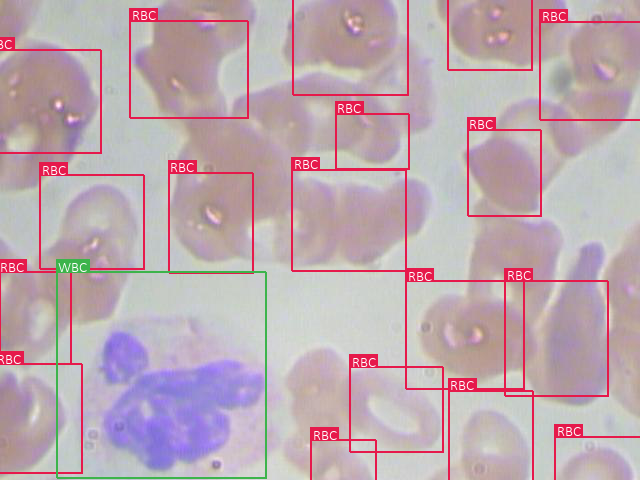

In [20]:
from detect import*
from IPython.display import display
img_path = './data/BCCD/JPEGImages/BloodImage_00001.jpg'
original_image = Image.open(img_path, mode='r')
original_image = original_image.convert('RGB')
det_img = detect(original_image, min_score=0.2, max_overlap=0.1, top_k=100)
display(det_img)

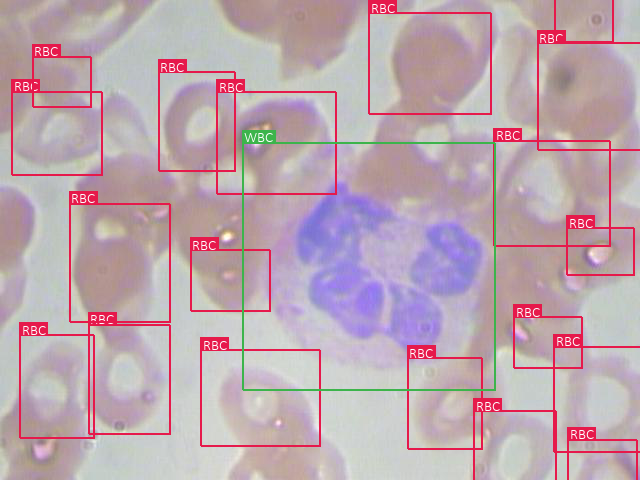

In [21]:
img_path = './data/BCCD/JPEGImages/BloodImage_00000.jpg'
original_image = Image.open(img_path, mode='r')
original_image = original_image.convert('RGB')
det_img = detect(original_image, min_score=0.2, max_overlap=0.1, top_k=100)
display(det_img)

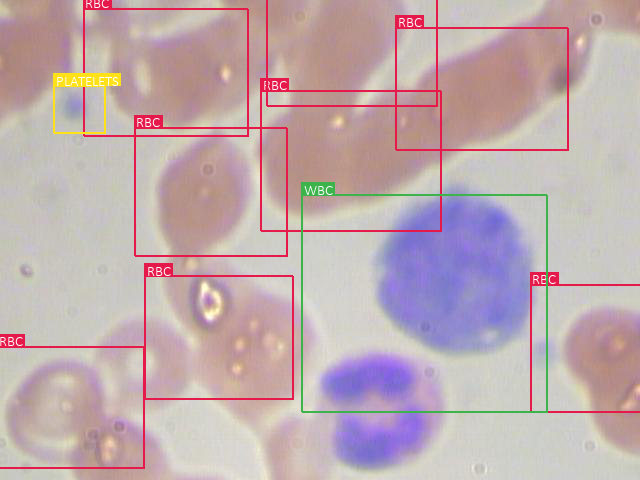

In [23]:
img_path = './data/BCCD/JPEGImages/BloodImage_00034.jpg'
original_image = Image.open(img_path, mode='r')
original_image = original_image.convert('RGB')
det_img = detect(original_image, min_score=0.2, max_overlap=0.1, top_k=100)
display(det_img)